# Gaussian Mixture Model

In this notebook, we try a parameter estimation for a Gaussian mixture model in Pystan. The model is based upon the [Stan users guide](https://mc-stan.org/docs/2_18/stan-users-guide/summing-out-the-responsibility-parameter.html). A workaround has been implemented because Stan is not able to work with discrete parameters, as explained in the users guide.

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from sklearn import datasets
sns.set()

Here, the model is defined in Stan.

In [3]:
gmm_code = """

data {
  int<lower=1> K;          // number of mixture components
  int<lower=1> N;          // number of data points
  int<lower=1> D;          // number of variables
  matrix[N,D] y;               // observations
}

parameters {
  simplex[K] theta;          // mixing proportions
  matrix[K,D] mu;            // locations of mixture components
  matrix<lower=0,upper=50>[K,D] sigma;  // scales of mixture components
}

model {
    vector[K] log_theta = log(theta);  // cache log calculation
    for (n in 1:N){
        vector[K] lps = log_theta;
        for (k in 1:K)
            lps[k] += normal_lpdf(y[n,:] | mu[k,:], sigma[k,:]);
            target += log_sum_exp(lps);
        }
}

generated quantities{
    matrix[N,K] z;
    
    for (n in 1:N){
        for (k in 1:K){
            z[n,k]=0.0;
        }
    }
    
    
    for (n in 1:N){
        for (k in 1:K){
            for (d in 1:D){
                z[n,k] += normal_lpdf(y[n,d]|mu[k,d], sigma[k,d]);
            }
            z[n,k] += log(theta[k]);
        }
    }
    
}


"""
gmm = pystan.StanModel(model_code=gmm_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d6bde024811be7472c0c14d2250cea7e NOW.


We specify our parameters and generate some data.

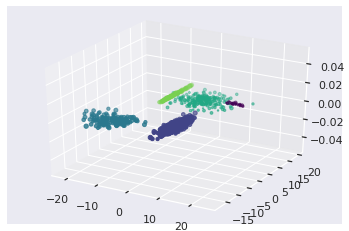

sample theta:  [0.034, 0.449, 0.129, 0.221, 0.08, 0.087]

sample mu_0:  [11.616962552059235, 12.062203853226372, 3.1447386943078075]
sample sigma_0: [1.7874520600229356, 0.3647907697762694, 3.7416428116016207]

sample mu_1:  [6.33932809444798, -7.956736653104511, 13.741857620741605]
sample sigma_1: [1.1782552775107684, 3.067907300252495, 3.426438478630519]

sample mu_2:  [-11.470108641330468, -11.58805172315406, 13.488286915491898]
sample sigma_2: [3.863543608568575, 2.4040433224320266, 2.8344009594014805]

sample mu_3:  [1.9109689659905464, 10.427875476303976, 6.037241456809861]
sample sigma_3: [3.847129808312688, 2.8652196383004185, 1.8658654140460502]

sample mu_4:  [-7.665315505112822, 11.015275138246398, 14.272123480311809]
sample sigma_4: [0.14692145200709075, 3.6695732188453247, 3.8120762263967998]

sample mu_5:  [14.19088238645117, 5.109843200654281, -6.410885263588334]
sample sigma_5: [3.316984452695356, 1.351983341269992, 0.3536919091242823]



In [17]:
N=1000
K=6
D=3
y_gmm = []
z_gmm = []
mu = np.random.uniform(-15,15,size=(K,D))
sigmas = np.random.uniform(0,5,size=(K,D))
theta = np.random.dirichlet(np.ones(K))
for i in range(N):
    opt = np.random.choice(list(range(K)),p=theta)
    z_gmm.append(opt)
    y_gmm.append(np.random.normal(mu[opt],sigmas[opt]))
y_gmm = np.array(y_gmm)

sns.set()

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plt.scatter(y_gmm[:,0], y_gmm[:,1], y_gmm[:,2], c=z_gmm, cmap='viridis')
plt.show()

sample_theta = []
sample_sigma = []
sample_mu = []

for k in range(K):
    sample_theta.append(len(y_gmm[np.array(z_gmm)==k])/N)
    sample_mu.append(list(np.mean(y_gmm[np.array(z_gmm)==k], axis=0)))
    sample_sigma.append(list(np.std(y_gmm[np.array(z_gmm)==k].T,axis=1)))

print('sample theta: ', sample_theta)
print()
for k in range(K):
    print('sample mu_'+str(k)+': ', sample_mu[k])
    print('sample sigma_'+str(k)+':', sample_sigma[k])
    print()

And then we can optimize our parameters and latent dataset.

In [18]:
gmm_dat = {'N': N,'K': K, 'D':D, 'y':y_gmm}
fit = gmm.sampling(data=gmm_dat, chains=1, iter=100)
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [19]:
theta_sim = fit_ext['theta'][best_ind]
mu_sim = fit_ext['mu'][best_ind]
sigmas_sim = fit_ext['sigma'][best_ind]
z_sim = fit_ext['z'][best_ind]


print('Sample theta: ',sample_theta)
print('Simulated theta: ',theta_sim)
print()
print('Sample mu: ',sample_mu)
print('Simulated mu: ',mu_sim)
print()
print('Sample sigmas: ',sample_sigma)
print('Simulated sigmas: ',sigmas_sim)

Sample theta:  [0.034, 0.449, 0.129, 0.221, 0.08, 0.087]
Simulated theta:  [4.28998877e-01 8.63522034e-02 2.78392192e-01 9.50113154e-04
 2.05150765e-01 1.55850259e-04]

Sample mu:  [[11.616962552059235, 12.062203853226372, 3.1447386943078075], [6.33932809444798, -7.956736653104511, 13.741857620741605], [-11.470108641330468, -11.58805172315406, 13.488286915491898], [1.9109689659905464, 10.427875476303976, 6.037241456809861], [-7.665315505112822, 11.015275138246398, 14.272123480311809], [14.19088238645117, 5.109843200654281, -6.410885263588334]]
Simulated mu:  [[   6.3799662    -7.85299691   13.785955  ]
 [  14.39115862    5.03316571   -6.44136329]
 [   2.63804379   10.72004171    5.84365988]
 [  24.33812419   -6.01668517   56.14638664]
 [ -10.12389742   -2.59370082   14.01257651]
 [ 130.69381826 -215.94745125  -19.21191294]]

Sample sigmas:  [[1.7874520600229356, 0.3647907697762694, 3.7416428116016207], [1.1782552775107684, 3.067907300252495, 3.426438478630519], [3.863543608568575, 2.40

In [20]:
z_cats = []
for n in range(N):
    for k in range(K):
        if z_sim[n,k] == max(z_sim[n]):
            z_cats.append(k)
            break

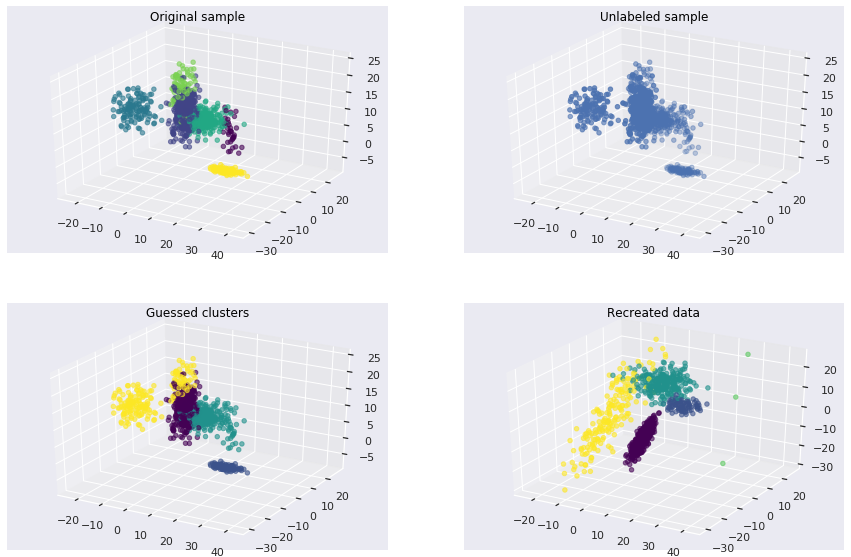

In [23]:
z_sim_rec, y_sim = [], []
for i in range(N):
    opt = np.random.choice(list(range(K)),p=theta_sim)
    z_sim_rec.append(opt)
    y_sim.append(np.random.normal(mu_sim[opt],sigmas_sim[opt]))

y_sim = np.array(y_sim)    
    
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2,2,1, projection='3d')
ax.scatter(np.array(y_gmm)[:,0], np.array(y_gmm)[:,1], np.array(y_gmm)[:,2], c=z_gmm, cmap='viridis', alpha=0.6)
ax.set_xlim(min(np.min(y_gmm[:,0]),np.min(y_sim[:,0]))-5,max(np.max(y_gmm[:,0]),np.max(y_sim[:,0]))+5)
ax.set_ylim(min(np.min(y_gmm[:,1]),np.min(y_sim[:,1]))-5,max(np.max(y_gmm[:,1]),np.max(y_sim[:,1]))+5)
title = ax.set_title("Original sample")
plt.setp(title, color='black') 

ax = fig.add_subplot(2,2,2, projection='3d')
ax.scatter(np.array(y_gmm)[:,0], np.array(y_gmm)[:,1], np.array(y_gmm)[:,2], cmap='viridis')
ax.set_xlim(min(np.min(y_gmm[:,0]),np.min(y_sim[:,0]))-5,max(np.max(y_gmm[:,0]),np.max(y_sim[:,0]))+5)
ax.set_ylim(min(np.min(y_gmm[:,1]),np.min(y_sim[:,1]))-5,max(np.max(y_gmm[:,1]),np.max(y_sim[:,1]))+5)
title = ax.set_title("Unlabeled sample")
plt.setp(title, color='black') 

ax = fig.add_subplot(2,2,3, projection='3d')
ax.scatter(np.array(y_gmm)[:,0], np.array(y_gmm)[:,1], np.array(y_gmm)[:,2], c=z_cats, cmap='viridis', alpha=0.6)
ax.set_xlim(min(np.min(y_gmm[:,0]),np.min(y_sim[:,0]))-5,max(np.max(y_gmm[:,0]),np.max(y_sim[:,0]))+5)
ax.set_ylim(min(np.min(y_gmm[:,1]),np.min(y_sim[:,1]))-5,max(np.max(y_gmm[:,1]),np.max(y_sim[:,1]))+5)
title = ax.set_title("Guessed clusters")
plt.setp(title, color='black') 

ax = fig.add_subplot(2,2,4, projection='3d')
ax.scatter(np.array(y_sim)[:,0], np.array(y_sim)[:,1], np.array(y_sim)[:,1], c=z_sim_rec, cmap='viridis', alpha=0.6)
ax.set_xlim(min(np.min(y_gmm[:,0]),np.min(y_sim[:,0]))-5,max(np.max(y_gmm[:,0]),np.max(y_sim[:,0]))+5)
ax.set_ylim(min(np.min(y_gmm[:,1]),np.min(y_sim[:,1]))-5,max(np.max(y_gmm[:,1]),np.max(y_sim[:,1]))+5)
title = ax.set_title("Recreated data")
plt.setp(title, color='black') 
plt.show()

As we can see, all parameters are estimated accurately.